# Alarm Counts

The `alarm_data.csv` file contains all alarms of the cleaned CHARTEVENTS (`chartevents_clean.parquet`) and is available on the server in the folder `/data/alarms/` like the file `alarm_violations.csv`.

## Alarm Counts by Vital Parameter and Alarm Type

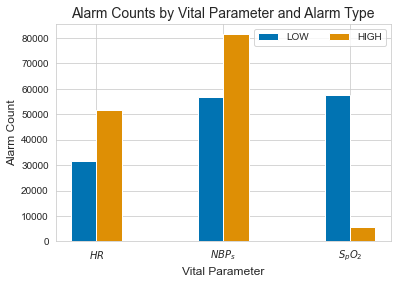

THRESHOLD_TYPE,HIGH,LOW
ITEMID_LABEL,,
$HR$,51716,31716
$NBP_s$,81454,56978
$S_pO_2$,5725,57761


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Read alarm data
alarm_data = pd.read_csv('../../data/alarms/alarm_data.csv')

# Add column for label of ITEMID
alarm_data.insert(loc=len(alarm_data.columns), column='ITEMID_LABEL', value=np.nan)
alarm_data.loc[alarm_data['ITEMID'] == 220045, 'ITEMID_LABEL'] = '$HR$'
alarm_data.loc[alarm_data['ITEMID'] == 220179, 'ITEMID_LABEL'] = '$NBP_s$'
alarm_data.loc[alarm_data['ITEMID'] == 220277, 'ITEMID_LABEL'] = '$S_pO_2$'

# Prepare plot data
alarms_by_itemid_type = alarm_data\
    .groupby(['ITEMID_LABEL', 'THRESHOLD_TYPE'])\
    .size()\
    .reset_index(name='AlarmCount')
alarms_by_itemid_type = alarms_by_itemid_type.pivot(index='ITEMID_LABEL', columns='THRESHOLD_TYPE', values='AlarmCount')

# Actual plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, figsize=(6, 4))
x = np.arange(len(alarms_by_itemid_type.index))
plt.bar(x - 0.1, alarms_by_itemid_type['LOW'], width=0.2, color=sns.color_palette('colorblind')[0])
plt.bar(x + 0.1, alarms_by_itemid_type['HIGH'], width=0.2, color=sns.color_palette('colorblind')[1])
# Now we only use the colorblind palette for consistency reasons, but these are the original colour strings from our slides (see "Weekly_02", slide 7):
# LOW -> '#1D2F6F'
# HIGH -> '#8390FA'

# Add title, labels and legend
plt.title('Alarm Counts by Vital Parameter and Alarm Type', fontsize=14)
plt.xlabel('Vital Parameter', fontsize=12)
plt.ylabel('Alarm Count', fontsize=12)
plt.xticks(x, alarms_by_itemid_type.index)
plt.legend(['LOW', 'HIGH'], loc='upper right', ncol=2)

# Show figure and actual numbers
plt.show()
#fig.savefig('../../plots/paper_alarm_counts_parameter_type.pdf')
alarms_by_itemid_type

## Alarm Counts per ICU Stay ID

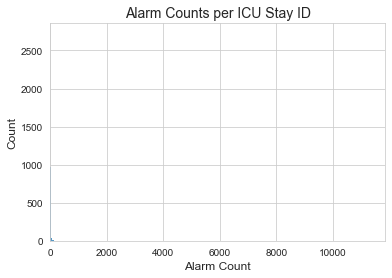

On average there are about 15 alarms per ICU stay.

There are 2720 out of 18813 ICU stays with only one alarm.

Most of the ICU stays have between 3 (25th percentile) and 16 (75th percentile) alarms.

There are 187 outliers (over 99.0th percentile), with 11289 alarms being the maximum for one single ICU stay.



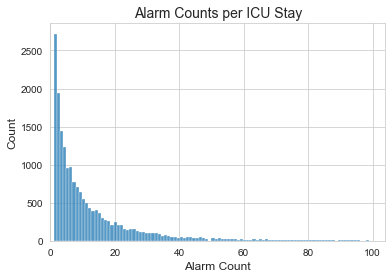

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Read alarm data
alarm_data = pd.read_csv('../../data/alarms/alarm_data.csv')

# Prepare plot data
alarms_by_icustay = alarm_data\
    .groupby(['ICUSTAY_ID'])\
    .size()\
    .reset_index(name='AlarmCount')

# Actual plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.histplot(data=alarms_by_icustay, x='AlarmCount', palette=sns.color_palette('colorblind'))

# Add title and adjust axes
plt.title('Alarm Counts per ICU Stay ID', fontsize=14)
plt.xlabel('Alarm Count', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(left=0)

# Show figure and print some insights
plt.show()
print(f'On average there are about {round(alarms_by_icustay.AlarmCount.mean())} alarms per ICU stay.\n')
print(f'There are {(alarms_by_icustay.AlarmCount.values == 1).sum()} out of {len(alarms_by_icustay)} ICU stays with only one alarm.\n')
print(f'Most of the ICU stays have between {round(alarms_by_icustay.AlarmCount.quantile(.25))} (25th percentile) and {round(alarms_by_icustay.AlarmCount.quantile(.75))} (75th percentile) alarms.\n')

# Note: We did not use percentiles to identify outliers for the plot in our slides (see "Weekly_02", slide 8)
outlier_percentile = .99
num_outliers = len(alarms_by_icustay[alarms_by_icustay.AlarmCount > alarms_by_icustay.AlarmCount.quantile(outlier_percentile)])
print(f'There are {num_outliers} outliers (over {outlier_percentile*100}th percentile), with {alarms_by_icustay.AlarmCount.max()} alarms being the maximum for one single ICU stay.\n')

# Plot alarm count per ICU stay without outliers (to have a more useful plot)
if num_outliers > 0:
    alarms_by_icustay_without_outliers = alarms_by_icustay[alarms_by_icustay.AlarmCount <= alarms_by_icustay.AlarmCount.quantile(outlier_percentile)]

    # Actual plot
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(1, figsize=(6, 4))
    sns.histplot(data=alarms_by_icustay_without_outliers, x='AlarmCount', palette=sns.color_palette('colorblind'))

    # Add title and adjust axes
    plt.title('Alarm Counts per ICU Stay', fontsize=14)
    plt.xlabel('Alarm Count', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xlim(left=0)

    # Show figure
    plt.show()
    #fig.savefig('../../plots/paper_alarm_counts_icu_stay.pdf')

## Number of Alarms Removed by Cleaning

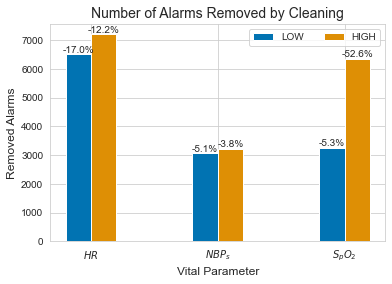

,ITEMID_LABEL,THRESHOLD_TYPE,ALARMS_ORIGINAL,ALARMS_CLEAN,ALARMS_REMOVED,PERCENT_REMOVED
0,$HR$,HIGH,58921,51716,7205,12.228238
1,$HR$,LOW,38227,31716,6511,17.032464
2,$NBP_s$,HIGH,84666,81454,3212,3.793731
3,$NBP_s$,LOW,60039,56978,3061,5.098353
4,$S_pO_2$,HIGH,12077,5725,6352,52.595843
5,$S_pO_2$,LOW,61024,57761,3263,5.347077



Percentage removed of all HIGH alarms: 10.77%
Percentage removed of all LOW alarms: 8.06%


In [3]:
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Read alarm data
alarm_data_original = pd.read_csv('../../data/alarms/alarm_violations.csv')
alarm_data_clean = pd.read_csv('../../data/alarms/alarm_data.csv')

# Add column for label of ITEMID
for alarm_data in [alarm_data_original, alarm_data_clean]:
    alarm_data.insert(loc=len(alarm_data.columns), column='ITEMID_LABEL', value=np.nan)
    alarm_data.loc[alarm_data['ITEMID'] == 220045, 'ITEMID_LABEL'] = '$HR$'
    alarm_data.loc[alarm_data['ITEMID'] == 220179, 'ITEMID_LABEL'] = '$NBP_s$'
    alarm_data.loc[alarm_data['ITEMID'] == 220277, 'ITEMID_LABEL'] = '$S_pO_2$'

# Prepare plot data with original alarms
plotdata_original = alarm_data_original\
    .groupby(['ITEMID_LABEL', 'THRESHOLD_TYPE'])\
    .size()\
    .reset_index(name='ALARMS_ORIGINAL')

# Prepare plot data with cleaned alarms
plotdata_clean = alarm_data_clean\
    .groupby(['ITEMID_LABEL', 'THRESHOLD_TYPE'])\
    .size()\
    .reset_index(name='ALARMS_CLEAN')

# Merge dataframes and add columns (y-value and bar info)
plotdata = pd.merge(plotdata_original, plotdata_clean, on=['ITEMID_LABEL', 'THRESHOLD_TYPE'])
plotdata['ALARMS_REMOVED'] = plotdata['ALARMS_ORIGINAL'] - plotdata['ALARMS_CLEAN']
plotdata['PERCENT_REMOVED'] = (plotdata['ALARMS_REMOVED'] * 100) / plotdata['ALARMS_ORIGINAL']

# Actual plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, figsize=(6, 4))
x_tick_labels = list(plotdata['ITEMID_LABEL'].unique())
x_pos = np.arange(len(x_tick_labels))
low_bar = plt.bar(x_pos - 0.1, plotdata[plotdata['THRESHOLD_TYPE'] == 'LOW'].ALARMS_REMOVED, width=0.2, color=sns.color_palette('colorblind')[0])
high_bar = plt.bar(x_pos + 0.1, plotdata[plotdata['THRESHOLD_TYPE'] == 'HIGH'].ALARMS_REMOVED, width=0.2, color=sns.color_palette('colorblind')[1])

# Add percentages above the bars
for i, rect in enumerate(low_bar):
    height = rect.get_height()
    percentage = round(plotdata.PERCENT_REMOVED[i*2+1], 1)
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'-{percentage}%', ha='center', va='bottom')

for i, rect in enumerate(high_bar):
    height = rect.get_height()
    percentage = round(plotdata.PERCENT_REMOVED[i*2], 1)
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'-{percentage}%', ha='center', va='bottom')

# Add title, labels and legend
plt.title('Number of Alarms Removed by Cleaning', fontsize=14)
plt.xlabel('Vital Parameter', fontsize=12)
plt.ylabel('Removed Alarms', fontsize=12)
plt.xticks(x_pos, x_tick_labels)
plt.legend(['LOW', 'HIGH'], loc='upper right', ncol=2)

# Show and save plot
plt.show()
#fig.savefig('../../plots/paper_alarms_removed.pdf')

# Plot actual numbers and overall percentages
display(plotdata)

orig_sum_high = plotdata[plotdata['THRESHOLD_TYPE'] == 'HIGH'].ALARMS_ORIGINAL.sum()
removed_sum_high = plotdata[plotdata['THRESHOLD_TYPE'] == 'HIGH'].ALARMS_REMOVED.sum()
percent_removed_high = (removed_sum_high * 100) / orig_sum_high
print(f'\nPercentage removed of all HIGH alarms: {round(percent_removed_high, 2)}%')

orig_sum_low = plotdata[plotdata['THRESHOLD_TYPE'] == 'LOW'].ALARMS_ORIGINAL.sum()
removed_sum_low = plotdata[plotdata['THRESHOLD_TYPE'] == 'LOW'].ALARMS_REMOVED.sum()
percent_removed_low = (removed_sum_low * 100) / orig_sum_low
print(f'Percentage removed of all LOW alarms: {round(percent_removed_low, 2)}%')

## Alarm Counts by Vital Parameter and Alarm Type (Before & After Cleaning)

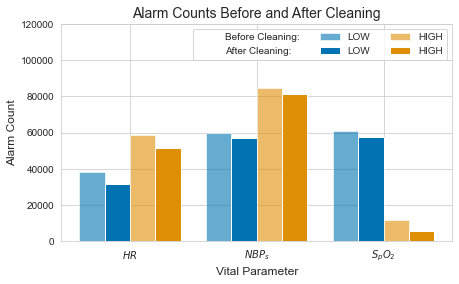

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Read alarm data
alarm_data_original = pd.read_csv('../../data/alarms/alarm_violations.csv')
alarm_data_clean = pd.read_csv('../../data/alarms/alarm_data.csv')

# Add column for label of ITEMID
for alarm_data in [alarm_data_original, alarm_data_clean]:
    alarm_data.insert(loc=len(alarm_data.columns), column='ITEMID_LABEL', value=np.nan)
    alarm_data.loc[alarm_data['ITEMID'] == 220045, 'ITEMID_LABEL'] = '$HR$'
    alarm_data.loc[alarm_data['ITEMID'] == 220179, 'ITEMID_LABEL'] = '$NBP_s$'
    alarm_data.loc[alarm_data['ITEMID'] == 220277, 'ITEMID_LABEL'] = '$S_pO_2$'

# Prepare plot data with original alarms
plotdata_original = alarm_data_original\
    .groupby(['ITEMID_LABEL', 'THRESHOLD_TYPE'])\
    .size()\
    .reset_index(name='ALARMS_ORIGINAL')

# Prepare plot data with cleaned alarms
plotdata_clean = alarm_data_clean\
    .groupby(['ITEMID_LABEL', 'THRESHOLD_TYPE'])\
    .size()\
    .reset_index(name='ALARMS_CLEAN')

# Merge dataframes
plotdata = pd.merge(plotdata_original, plotdata_clean, on=['ITEMID_LABEL', 'THRESHOLD_TYPE'])

# Actual plot
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, figsize=(7, 4))
x_tick_labels = list(plotdata['ITEMID_LABEL'].unique())
x_pos = np.arange(len(x_tick_labels))

low_before = ax.bar(x_pos - 0.3, plotdata[plotdata['THRESHOLD_TYPE'] == 'LOW'].ALARMS_ORIGINAL, width=0.2, color=sns.color_palette('colorblind')[0], alpha=0.6, label='LOW')
low_after = ax.bar(x_pos - 0.1, plotdata[plotdata['THRESHOLD_TYPE'] == 'LOW'].ALARMS_CLEAN, width=0.2, color=sns.color_palette('colorblind')[0], label='LOW')

high_before = ax.bar(x_pos + 0.1, plotdata[plotdata['THRESHOLD_TYPE'] == 'HIGH'].ALARMS_ORIGINAL, width=0.2, color=sns.color_palette('colorblind')[1], alpha=0.6, label='HIGH')
high_after = ax.bar(x_pos + 0.3, plotdata[plotdata['THRESHOLD_TYPE'] == 'HIGH'].ALARMS_CLEAN, width=0.2, color=sns.color_palette('colorblind')[1], label='HIGH')

# Adjust title and axes
plt.title('Alarm Counts Before and After Cleaning', fontsize=14)
plt.xlabel('Vital Parameter', fontsize=12)
plt.ylabel('Alarm Count', fontsize=12)
plt.xticks(x_pos, x_tick_labels)
plt.ylim(top=120000)

# Add legend
h, l = ax.get_legend_handles_labels()
ph = [plt.bar([], [])] * 2
handles = ph + h
labels = ['Before Cleaning:', 'After Cleaning:'] + l
legend = ax.legend(handles, labels, ncol=3)
legend.legendHandles[0].set_visible(False)
legend.legendHandles[1].set_visible(False)

# Show and save plot
plt.show()
#fig.savefig('../../plots/paper_alarm_counts_before_after.pdf')